<a href="https://colab.research.google.com/github/omanshuthapliyal/AML-demo/blob/master/adversarial_attack_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Modified from original code by Rajeev Sahay & Prof. Aly El Gamal, for ECE 595 Fall 2019

# Training classifier on MNIST

In [0]:
#Install Cleverhans (version Cleverhans 2.1.0 is most compatable with Python 2.x)
!pip install cleverhans==2.1.0

#Import necessary packages
from keras.datasets import mnist
from keras import Sequential
from keras.layers import Dense, BatchNormalization
from keras import backend
import keras
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from cleverhans.utils_keras import KerasModelWrapper
from cleverhans.attacks import FastGradientMethod, MadryEtAl, DeepFool, CarliniWagnerL2

## Downloading & preprocessing data

In [0]:
#Load MNIST data and normalize to [-1, 1]
(data_train, labels_train), (data_test, labels_test) = mnist.load_data()
data_train = 2*(data_train/255.0 - 0.5)
data_test = 2*(data_test/255.0 - 0.5)
labels_train = keras.utils.np_utils.to_categorical(labels_train, num_classes=10)
labels_test = keras.utils.np_utils.to_categorical(labels_test, num_classes=10)
#Reshape training and testing data into 784-dimensional vectors
try:
  d = data_train.shape[1]
  data_train = data_train.reshape((data_train.shape[0], 
                                  d*d))
  data_test = data_test.reshape((data_test.shape[0], 
                               d*d))
except:
  print("training data shape: ", data_train.shape)
  print("testing data shape: ", data_test.shape)
  print("Data was reshaped already")
nClasses = 10

## CNN model

In [0]:
def nnModel():
  model = Sequential()
  model.add(Dense(100,input_dim=data_test.shape[1],
                activation="relu") )
  model.add(BatchNormalization(axis=-1,momentum=0.99))
  model.add(Dense(100, activation="relu", 
                  kernel_initializer = "uniform") )
  model.add(BatchNormalization(axis=-1,momentum=0.99))
  model.add(Dense(nClasses, activation = 'softmax'))  
  return model

### Utility function for plotting

In [0]:
def tenPlotter(mdl, test, attack, str1):
  # Plots ten unattacked images, and ten attacked images, 
  # with their corresponding labels as output by the classifier
  random_ind = np.random.choice(attack.shape[0], 10)
  fig, axs = plt.subplots(2, 10)
  unattacked_labels = mdl.predict_classes(test[random_ind])
  attacked_labels = mdl.predict_classes(attack[random_ind])
  for i in range(10):
    axs[0,i].imshow((test[random_ind[i]].reshape(28, 28)), cmap='gray')
    axs[0,i].title.set_text(str(unattacked_labels[i]))
    axs[0,i].axis('off')
    axs[1,i].imshow((attack[random_ind[i]].reshape(28, 28)), cmap='gray')
    axs[1,i].title.set_text(str(attacked_labels[i]))
    axs[1,i].axis('off')
  fig.suptitle('Original images [above] and '+str1+' Attack samples [below]', fontsize=18)

## Training CNN

In [0]:
#Training model
classifier = nnModel()
classifier.compile(loss='categorical_crossentropy',
                  optimizer = "adam", 
                  metrics = ['accuracy'])
print(classifier.summary())

classifier_metaData = classifier.fit(data_train, labels_train,
                           validation_data = (data_test, labels_test), 
                           epochs = 50, batch_size = 256, 
                           shuffle = True, verbose=False)

#Print accuracy of classifier on MNIST testing data
scores = classifier.evaluate(data_test, labels_test)
print("Accuracy: %0.4f%%" %(scores[1]*100) )

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 100)               78500     
_________________________________________________________________
batch_normalization_9 (Batch (None, 100)               400       
_________________________________________________________________
dense_14 (Dense)             (None, 100)               10100     
_________________________________________________________________
batch_normalization_10 (Batc (None, 100)               400       
_________________________________________________________________
dense_15 (Dense)             (None, 10)                1010      
Total params: 90,410
Trainable params: 90,010
Non-trainable params: 400
_________________________________________________________________
None
10000/10000 [==============================] - 0s 45us/step
Accuracy: 97.3900%


# Attack Generation
### Using Cleverhans 

In [0]:
#Get TensorFlow Session to pass into Cleverhans modules
sess = backend.get_session()

#Create wrapper for classifier model so that it can be passed into Cleverhans modules
wrap = KerasModelWrapper(model)

## FGSM attack

In [0]:
#Implementing the FGSM attack
FGM = FastGradientMethod(wrap, sess = sess)
#Attack parameters
FGM_params = {'eps': 0.25,
              'clip_min': 0.0,
              'clip_max': 1.0}
#Generate adversarial data
FGM_attack_data = FGM.generate_np(data_test, **FGM_params)

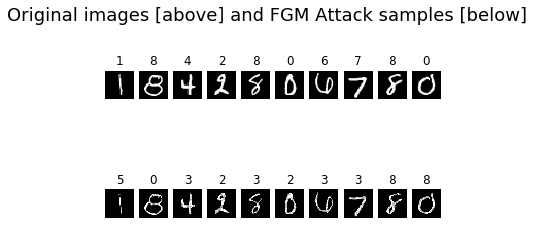

In [0]:
#Plotting
tenPlotter(classifier, data_test, FGM_attack_data, 'FGM')

## Projected Gradient Descent Attack

In [0]:
#Implementing the PGD attack
PGD = MadryEtAl(wrap, sess=sess)
#Attack parameters
PGD_params = {'eps': 0.25,
              'eps_iter': 0.01,
              'nb_iter': 20,
              'clip_min': 0.0,
              'clip_max': 1.0}
#Generate adversarial data
PGD_attack_data = PGD.generate_np(data_test, **PGD_params)

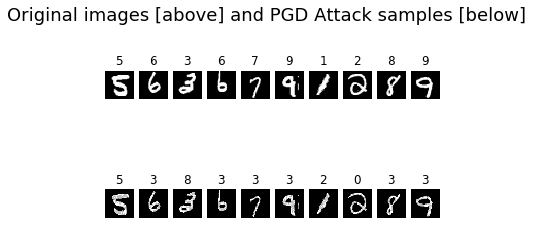

In [0]:
#Plotting
tenPlotter(classifier, data_test, PGD_attack_data, 'PGD')

## Carlini Wagner Attack

In [0]:
#Implementing the CW attack
CW = CarliniWagnerL2(wrap, sess = sess)
#Attack parameters
CW_params = {'binary_search_steps': 1,
             'y': None,
             'batch_size': 16,
             'learning_rate': 1.25,
             'initial_const': 10,
             'clip_min': 0.0,
             'clip_max': 1.0}
#Generate adversarial data
CW_attack_data = CW.generate_np(data_test, **CW_params)

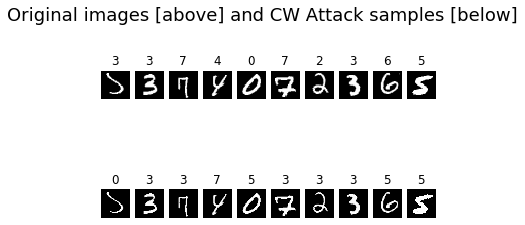

In [0]:
#Plotting
tenPlotter(classifier, data_test, CW_attack_data, 'CW')

## DeepFool Attack

In [0]:
#Implementing the DeepFool attack
DF = DeepFool(wrap, sess = sess)
DF_params = {'np_candidate': 10,
             'max_iter': 50,
             'clip_min': 0.0,
             'clip_max': 1.0}
#Generate adversarial data
DF_attack_data = DF.generate_np(data_test, **DF_params)

/usr/local/lib/python3.6/dist-packages/cleverhans/attacks.py:179: UserWarning: Supplied extra keyword arguments that are not used in the graph computation. They have been ignored.
  warnings.warn("Supplied extra keyword arguments that are not "


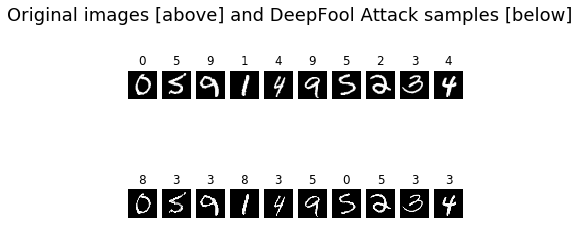

In [0]:
#Plotting 
tenPlotter(classifier, data_test, DF_attack_data, 'DeepFool')